# Target Scan ReAct Agent 

![Screenshot 2025-06-08 at 15.45.01.png](<attachment:Screenshot 2025-06-08 at 15.45.01.png>)
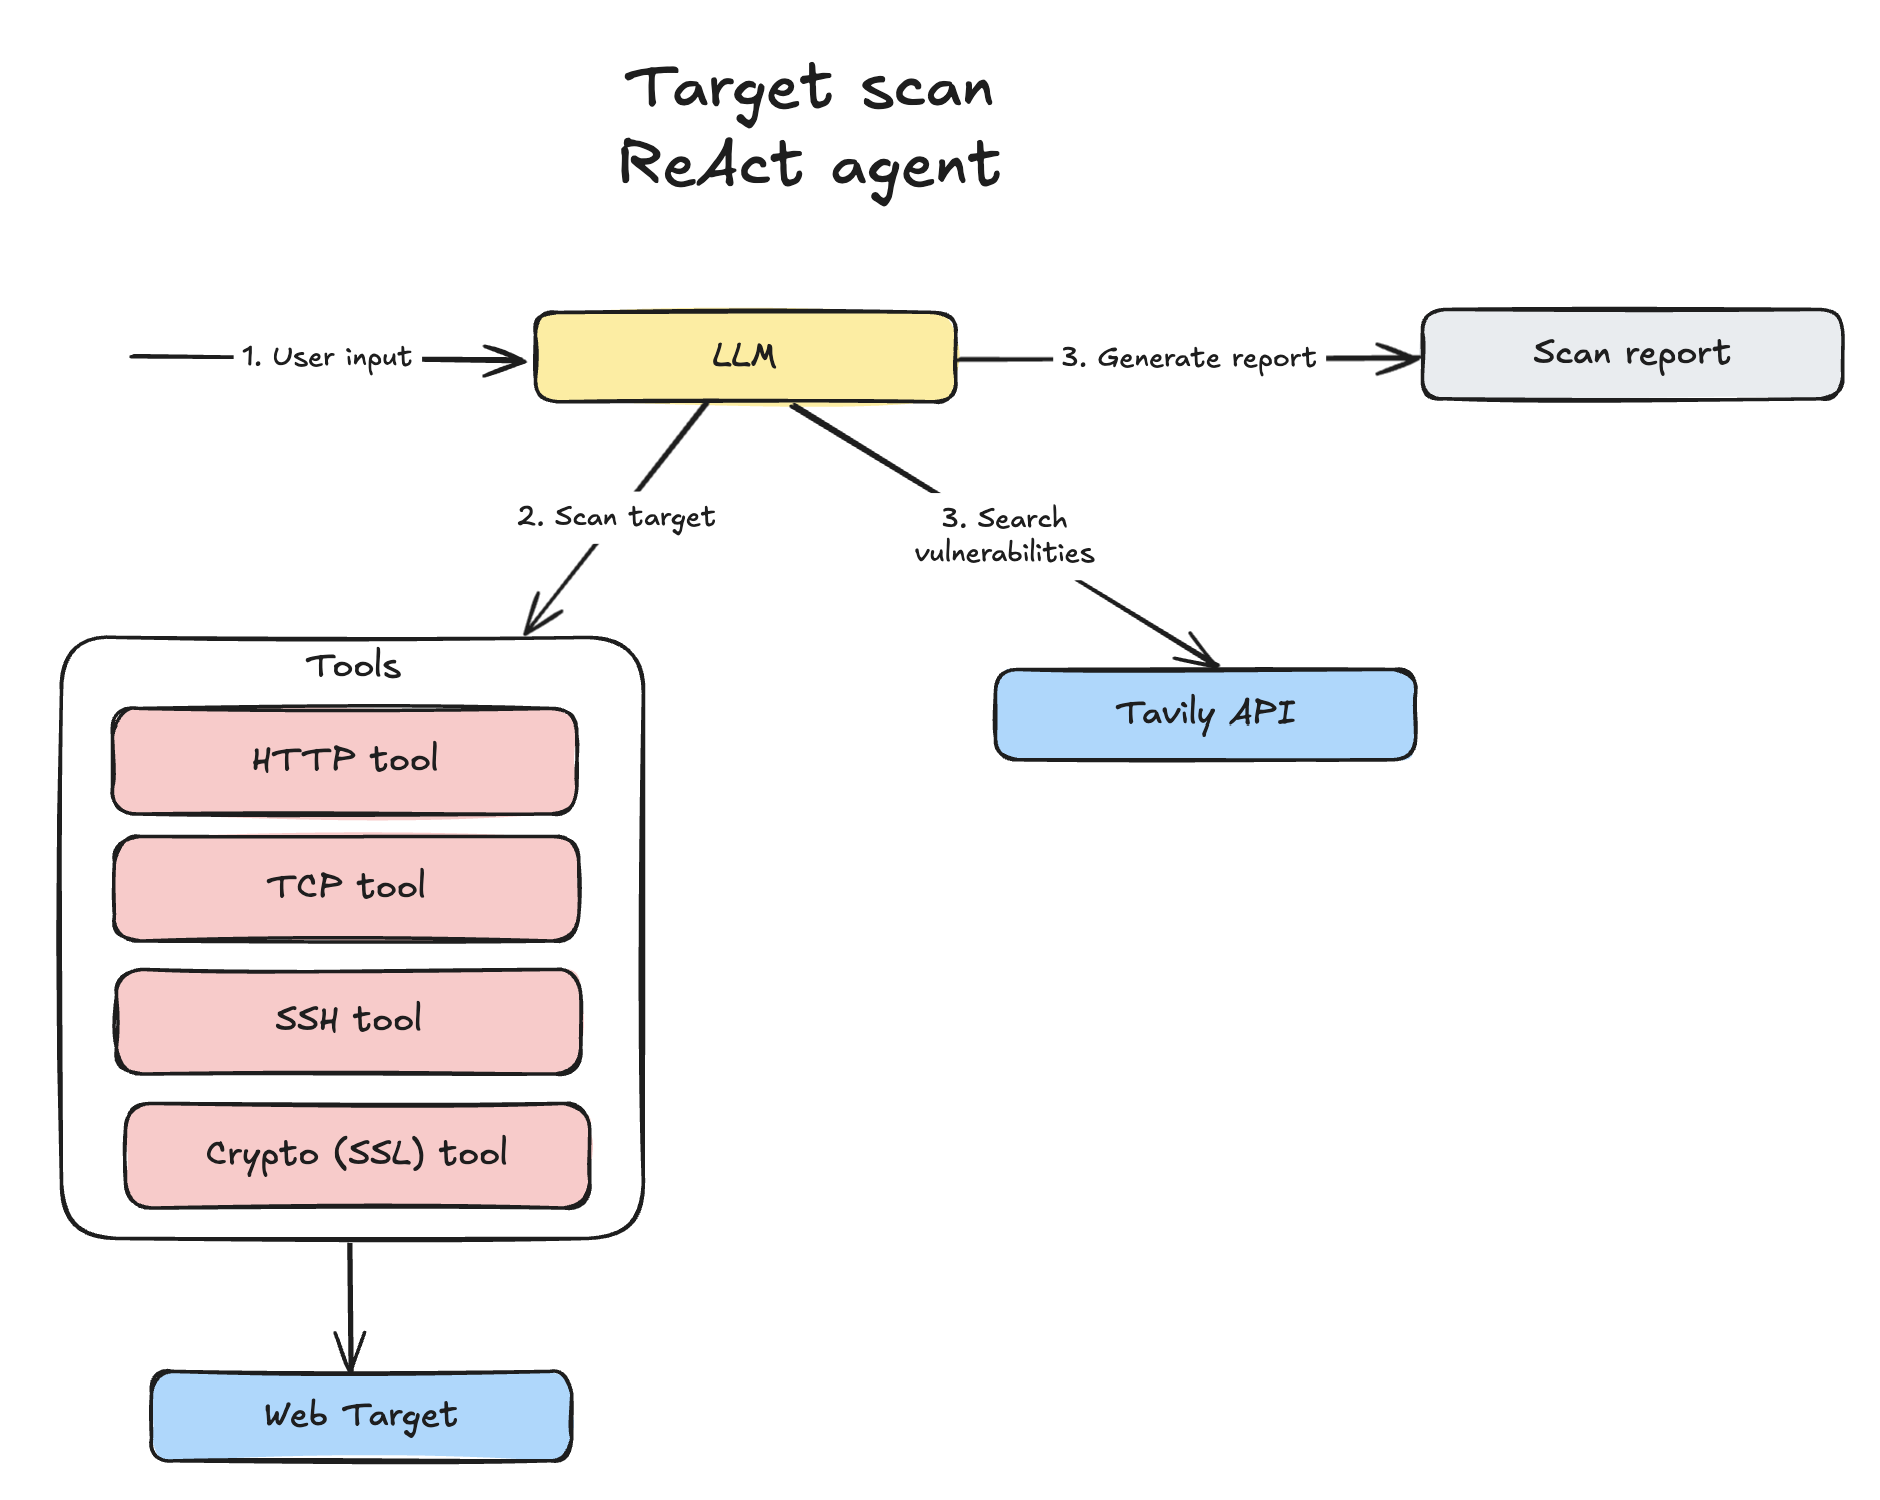

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

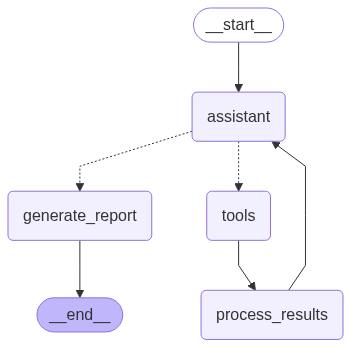

In [4]:
from target_scan_agent.graph import create_graph
from IPython.display import Image, display

graph = create_graph()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Balanced Jupyter Streaming Cell

from target_scan_agent.state import Target
from target_scan_agent.graph import create_graph
import time

target = Target(description="Security test", url="http://localhost:8000")
graph = create_graph()

print("🚀 Starting security scan...")
start_time = time.time()

async for event in graph.astream({"target": target}):
    elapsed = time.time() - start_time
    
    for node_name, node_data in event.items():
        timestamp = f"[{elapsed:5.1f}s]"
        
        if node_name == "assistant":
            # AI Message
            if "messages" in node_data and node_data["messages"]:
                last_msg = node_data["messages"][-1]
                
                if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
                    # AI is calling tools
                    tool_names = [tc.get('name', 'unknown') for tc in last_msg.tool_calls]
                    print(f"{timestamp} 🤖 AI: Calling tools → {', '.join(tool_names)}")
                else:
                    # AI is reasoning/responding
                    content = getattr(last_msg, 'content', '')
                    preview = content[:80].replace('\n', ' ') if content else "Analyzing..."
                    print(f"{timestamp} 🤖 AI: {preview}...")
        
        elif node_name == "tools":
            # Tool Results
            if "messages" in node_data:
                tool_messages = [m for m in node_data["messages"] if hasattr(m, 'type') and m.type == 'tool']
                
                for tool_msg in tool_messages:
                    tool_name = getattr(tool_msg, 'name', 'unknown')
                    content = str(tool_msg.content)
                    
                    # Check if tool found something interesting
                    if any(keyword in content.lower() for keyword in ['found', '200', 'discovered', 'vulnerable']):
                        status = "✅ Found results"
                    elif any(keyword in content.lower() for keyword in ['error', 'failed', 'timeout']):
                        status = "❌ Error occurred"
                    else:
                        status = "⚪ Completed"
                    
                    print(f"{timestamp} 🛠️  TOOL: {tool_name} → {status}")
        
        elif node_name == "generate_report":
            # Final Report
            if "summary" in node_data and node_data["summary"]:
                summary_length = len(str(node_data["summary"]))
                print(f"{timestamp} 📋 REPORT: Generated final report ({summary_length} chars)")
            else:
                print(f"{timestamp} 📋 REPORT: Preparing final report...")

# Get final state
final_state = event
total_time = time.time() - start_time

print(f"\n🎉 Scan completed in {total_time:.1f}s")

# Show quick summary
if final_state:
    for node_name, node_data in final_state.items():
        if "results" in node_data:
            print(f"📊 Total scan results: {len(node_data['results'])}")
        if "summary" in node_data and node_data["summary"]:
            print(f"📄 Final report ready")
            
print(f"💾 Final state available in 'final_state' variable")

🚀 Starting security scan...
[  1.2s] 🤖 AI: Calling tools → nuclei_scan_tool, ffuf_directory_scan
🔄 Checking nuclei templates...
🚀 Starting nuclei scan: nuclei -u http://localhost:8000 -tags tech-detect,exposure,misconfig -o /var/folders/6n/0bv2_14x2r11pn4nngc0nnz80000gn/T/tmpa0fg7ztc.jsonl -jsonl -silent -rate-limit 15
📊 Scan in progress... (30s elapsed)
📊 Scan in progress... (60s elapsed)
📊 Scan in progress... (90s elapsed)
📊 Scan in progress... (120s elapsed)
📊 Scan in progress... (151s elapsed)
📊 Scan in progress... (181s elapsed)
📊 Scan in progress... (211s elapsed)
📊 Scan in progress... (241s elapsed)
📊 Scan in progress... (271s elapsed)
📊 Scan in progress... (301s elapsed)
📊 Scan in progress... (331s elapsed)
📊 Scan in progress... (361s elapsed)
📊 Scan in progress... (391s elapsed)
📊 Scan in progress... (422s elapsed)
✅ Nuclei completed (exit code: 0)
[437.8s] 🛠️  TOOL: nuclei_scan_tool → ✅ Found results
[437.8s] 🛠️  TOOL: ffuf_directory_scan → ✅ Found results
[441.6s] 🤖 AI: Call

In [7]:
for m in state['messages']:
    m.pretty_print()

NameError: name 'state' is not defined

In [11]:
from IPython.display import Markdown

Markdown(final_state["generate_report"]['summary'])

# Security Scan Report for http://localhost:8000

## 1. Found Technologies
- **Server Software**: Uvicorn
- **API Framework**: Swagger UI

## 2. Found Vulnerabilities
- **Public Swagger API Detected**
  - **Endpoint**: `http://localhost:8000/docs`
  - **Description**: Public Swagger API was detected, indicating potential exposure of API documentation.
  - **Severity**: Info
  - **Evidence**: Response includes Swagger UI HTML content.

- **OpenAPI Detected**
  - **Endpoint**: `http://localhost:8000/openapi.json`
  - **Description**: OpenAPI specification was detected, which may expose API structure and endpoints.
  - **Severity**: Info
  - **Evidence**: Response includes OpenAPI JSON content.

- **Missing HTTP Security Headers**
  - **Endpoint**: `http://localhost:8000`
  - **Details**: The following security headers were missing:
    - Cross-Origin-Opener-Policy
    - Content-Security-Policy
    - X-Frame-Options
    - X-Permitted-Cross-Domain-Policies
    - Cross-Origin-Embedder-Policy
    - Cross-Origin-Resource-Policy
    - Strict-Transport-Security
    - Permissions-Policy
    - X-Content-Type-Options
    - Referrer-Policy
    - Clear-Site-Data
  - **Severity**: Info
  - **Evidence**: 404 Not Found response for root URL.

## 3. Found Insights
- **Exposed Endpoints**
  - `http://localhost:8000/docs` - Swagger UI documentation available.
  - `http://localhost:8000/health` - Health check endpoint.
  - `http://localhost:8000/users` - User-related endpoint.

- **Unusual Responses**
  - **404 Not Found**: Multiple requests to `http://localhost:8000` returned 404, indicating potential misconfiguration or non-existent root endpoint.

- **Configuration Details**
  - **API Description**: The OpenAPI specification describes the API as intentionally vulnerable for security testing purposes.
  - **Vulnerabilities in API Endpoints**: The OpenAPI specification lists several endpoints with known vulnerabilities, including SQL Injection, command injection, and path traversal.

---

This report summarizes the confirmed findings from the security scans conducted on the specified target. No assumptions or recommendations are included, focusing solely on the factual data obtained from the scans.

In [ ]:
from target_scan_agent.tools import ffuf_directory_scan

ffuf_directory_scan("http://localhost:8000")

"🔍 FFUF Directory Discovery Results\n🎯 Target: http://localhost:8000\n📋 Wordlist: common (4,746 entries)\n🔧 Extensions: php,html,js,txt\n======================================================================\n\n📊 HTTP 200 (3 found):\n  ✅ http://localhost:8000/docs - 943 bytes\n  ✅ http://localhost:8000/health - 79 bytes\n  ✅ http://localhost:8000/users - 197 bytes\n\n💡 Summary: 3 endpoints discovered\n🎯 Recommended next steps:\n  1. Test discovered endpoints with nuclei_scan_tool\n  2. Manual inspection of 200/500 responses for sensitive data\n  3. Use api_endpoint_tester for SQL injection and XSS testing\n  5. Consider running wordlist_type='medium' for deeper coverage"